# COGS18 Final Project

In [53]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt

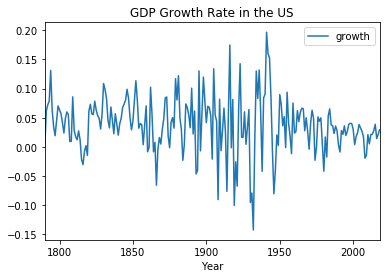

In [58]:
data_location = './data'

data_files = ['USCPI_1774-2018.csv', 'USGDP_1790-2018.csv']
 
data = pd.DataFrame()

cpi_df = pd.read_csv('./data/USCPI_1774-2018.csv')

def calc_append_inflation(cpi_data):
    prev_year = None
    
    cpi_series = cpi_data['CPI']

    inflation_rate = []
    for cpi in cpi_series:

        if prev_year == None:
            inflation_rate.append(0)
        else:
            if_rate = (cpi - prev_year)/prev_year
#             print(if_rate)
            inflation_rate.append(if_rate)
        
        prev_year = cpi
            
#     print(inflation_rate)
    cpi_data['inflation'] = inflation_rate

calc_append_inflation(cpi_df)

gdp_df = pd.read_csv('./data/USGDP_1790-2018.csv')

gdp_df = cpi_df.merge(gdp_df)

nom_gdp = 'Nominal GDP (million of Dollars)'

def calc_gdp_growth(gdp_data):
    prev_year = None
    
    gdp_series = gdp_data[nom_gdp]
    inflation_series = gdp_data['inflation']
    
    growth_rate = []
    for inflation, gdp in zip(inflation_series, gdp_series):
        gdp_f = float(gdp.replace(',', ''))
        
        if prev_year == None:
            growth_rate.append(0)
        else:
            if_amount = (inflation * prev_year) + prev_year
#             print(inflation, prev_year, if_amount)
            growth = (gdp_f - if_amount) / if_amount
#             growth = 1
            growth_rate.append(growth)
            
        prev_year = gdp_f
        
    return growth_rate

gdp_df['growth'] = calc_gdp_growth(gdp_df)
growth_chat = gdp_df[['Year', 'growth']].plot.line(x = 'Year', y = 'growth')
plt.title('GDP Growth Rate in the US')
plt.show(growth_chat)

